#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency, mannwhitneyu
import warnings
warnings.filterwarnings("ignore")
import re

## Data

In [28]:
# Cargar los datos
train_data = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Escritorio\competicion kaggel ML\train.csv")

In [29]:
# Mostrar las primeras filas del conjunto de datos
train_data.head()


,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [30]:
# Resumen estadístico del conjunto de datos
print(train_data.describe())

                id    laptop_ID      Inches  Price_euros
count   912.000000   912.000000  912.000000   912.000000
mean    645.091009   666.192982   15.011404  1108.122873
std     380.313813   384.873846    1.411744   714.597741
min       0.000000     1.000000   10.100000   174.000000
25%     319.750000   330.500000   14.000000   589.000000
50%     636.500000   673.500000   15.600000   949.000000
75%     980.250000   998.500000   15.600000  1458.500000
max    1302.000000  1320.000000   18.400000  6099.000000


In [31]:
# Información sobre los tipos de datos y valores nulos
train_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


## Data exploration

In [32]:
# Configuración de estilo de gráficos y paleta de colores
sns.set(style="darkgrid")
sns.set_palette("colorblind")  # Paleta de colores 'muted'

In [33]:
# Convertir la columna 'Weight' a formato numérico eliminando 'kg' y convirtiendo a float
train_data['Weight'] = train_data['Weight'].str.replace('kg', '').astype(float)
train_data['Ram'] = train_data['Ram'].str.replace('GB', '').astype(int)

In [34]:
# Eliminar las columnas 'id' y 'laptop_ID'
train_data = train_data.drop(['id', 'laptop_ID'], axis=1)

In [35]:
# Eliminar duplicados.
print(train_data.duplicated().sum())
print(train_data.shape)

train_data = train_data.drop_duplicates()
train_data.shape

19
(912, 12)


(893, 12)

In [36]:
# Asegurarse de que la columna 'Ram' esté en formato de cadena
train_data['Ram'] = train_data['Ram'].astype(str)

# Eliminar 'GB' de los valores de la columna 'Ram'
train_data['Ram'] = train_data['Ram'].str.replace('GB', '')

# Convertir la columna 'Ram' a formato int32
train_data['Ram'] = train_data['Ram'].astype('int32')

# Confirmar la conversión
print(train_data['Ram'].dtype)
train_data.head()



int32


,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36,749.00
1,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4,1TB HDD,Intel HD Graphics 505,Windows 10,2.00,449.00
2,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.20,1460.00
3,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42,2868.99
4,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.26,1713.37


In [37]:
# Screen resolution tratamiento
train_data['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                345
1366x768                                         195
IPS Panel Full HD 1920x1080                      162
IPS Panel Full HD / Touchscreen 1920x1080         35
Full HD / Touchscreen 1920x1080                   32
Touchscreen 1366x768                              15
1600x900                                          11
IPS Panel 4K Ultra HD 3840x2160                   10
4K Ultra HD / Touchscreen 3840x2160                8
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      8
Quad HD+ / Touchscreen 3200x1800                   8
IPS Panel Retina Display 2304x1440                 6
IPS Panel 1366x768                                 5
4K Ultra HD 3840x2160                              5
IPS Panel Retina Display 2560x1600                 5
IPS Panel Touchscreen 1920x1200                    4
IPS Panel Touchscreen 2560x1440                    4
Touchscreen 2560x1440                              4
Touchscreen 2256x1504        

In [38]:
# Crear una nueva columna 'Touchscreen' que indique si la pantalla es táctil
train_data['Touchscreen'] = train_data['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

# Confirmar la creación de la columna
print(train_data[['ScreenResolution', 'Touchscreen']].head())

                  ScreenResolution  Touchscreen
0                         1366x768            0
1                         1366x768            0
2                Full HD 1920x1080            0
3  IPS Panel 4K Ultra HD 3840x2160            0
4  Full HD / Touchscreen 1920x1080            1


In [39]:
# Separar la columna 'ScreenResolution' en ancho y alto
resolution_split = train_data['ScreenResolution'].str.split('x', expand=True)
train_data['ScreenWidth'] = resolution_split[0].str.extract('(\d+)').astype(int)
train_data['ScreenHeight'] = resolution_split[1].str.extract('(\d+)').astype(int)

# Confirmar la separación
print(train_data[['ScreenResolution', 'ScreenWidth', 'ScreenHeight']].head())


                  ScreenResolution  ScreenWidth  ScreenHeight
0                         1366x768         1366           768
1                         1366x768         1366           768
2                Full HD 1920x1080         1920          1080
3  IPS Panel 4K Ultra HD 3840x2160            4          2160
4  Full HD / Touchscreen 1920x1080         1920          1080


In [40]:
# Calcular la cantidad total de píxeles
train_data['TotalPixels'] = train_data['ScreenWidth'] * train_data['ScreenHeight']

# Confirmar el cálculo
print(train_data[['ScreenResolution', 'ScreenWidth', 'ScreenHeight', 'TotalPixels']].head())


                  ScreenResolution  ScreenWidth  ScreenHeight  TotalPixels
0                         1366x768         1366           768      1049088
1                         1366x768         1366           768      1049088
2                Full HD 1920x1080         1920          1080      2073600
3  IPS Panel 4K Ultra HD 3840x2160            4          2160         8640
4  Full HD / Touchscreen 1920x1080         1920          1080      2073600


In [41]:
"""
Separar ScreenResolution:

Usamos str.split('x', expand=True) para dividir la resolución en ancho y alto.
Usamos str.extract('(\d+)') para extraer los números y astype(int) para convertirlos a enteros.
Calcular Total de Píxeles:

Multiplicamos ScreenWidth por ScreenHeight para obtener el total de píxeles.
Esto lo hacemos con el objetivo de que el modelo relacione mejor el aumento de precio a mayor resolucion"""

"\nSeparar ScreenResolution:\n\nUsamos str.split('x', expand=True) para dividir la resolución en ancho y alto.\nUsamos str.extract('(\\d+)') para extraer los números y astype(int) para convertirlos a enteros.\nCalcular Total de Píxeles:\n\nMultiplicamos ScreenWidth por ScreenHeight para obtener el total de píxeles.\nEsto lo hacemos con el objetivo de que el modelo relacione mejor el aumento de precio a mayor resolucion"

In [52]:
# Estado del train_data 

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 893 entries, 0 to 910
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           893 non-null    object 
 1   Product           893 non-null    object 
 2   TypeName          893 non-null    object 
 3   Inches            893 non-null    float64
 4   ScreenResolution  893 non-null    object 
 5   Cpu               893 non-null    object 
 6   Ram               893 non-null    int32  
 7   Memory            893 non-null    object 
 8   Gpu               893 non-null    object 
 9   OpSys             893 non-null    object 
 10  Weight            893 non-null    float64
 11  Price_euros       893 non-null    float64
 12  Touchscreen       893 non-null    int64  
 13  ScreenWidth       893 non-null    int32  
 14  ScreenHeight      893 non-null    int32  
 15  TotalPixels       893 non-null    int32  
dtypes: float64(3), int32(4), int64(1), object(8)
memo

In [54]:
train_data['Cpu'].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     142
Intel Core i7 7700HQ 2.8GHz    102
Intel Core i7 7500U 2.7GHz      86
Intel Core i5 8250U 1.6GHz      54
Intel Core i5 6200U 2.3GHz      51
                              ... 
Intel Core i7 7660U 2.5GHz       1
AMD E-Series E2-9000 2.2GHz      1
Intel Core i3 6006U 2.2GHz       1
Intel Core i7 2.8GHz             1
AMD E-Series 9000 2.2GHz         1
Name: count, Length: 104, dtype: int64

In [55]:
# Crear la columna 'CpuType' para categorizar los procesadores en 5 valores
def categorize_cpu(cpu):
    if 'Intel Core i3' in cpu:
        return 'Intel Core i3'
    elif 'Intel Core i5' in cpu:
        return 'Intel Core i5'
    elif 'Intel Core i7' in cpu:
        return 'Intel Core i7'
    elif 'AMD' in cpu:
        return 'AMD'
    else:
        return 'Other'

train_data['CpuType'] = train_data['Cpu'].apply(categorize_cpu)

# Confirmar la creación de la columna 'CpuType'
print(train_data[['Cpu', 'CpuType']].head())


                                    Cpu        CpuType
0            Intel Core i7 7500U 2.7GHz  Intel Core i7
1  Intel Pentium Quad Core N4200 1.1GHz          Other
2            Intel Core i5 6200U 2.3GHz  Intel Core i5
3           Intel Core i7 7700HQ 2.8GHz  Intel Core i7
4            Intel Core i5 6300U 2.4GHz  Intel Core i5


In [56]:
# Tratamiento de memory 
train_data['Memory'].value_counts()

Memory
256GB SSD                        293
1TB HDD                          144
500GB HDD                         95
512GB SSD                         73
128GB SSD +  1TB HDD              61
128GB SSD                         54
256GB SSD +  1TB HDD              52
32GB Flash Storage                25
2TB HDD                           11
512GB SSD +  1TB HDD              10
64GB Flash Storage                10
1TB SSD                            9
256GB Flash Storage                7
1.0TB Hybrid                       6
32GB SSD                           5
180GB SSD                          5
256GB SSD +  2TB HDD               4
16GB Flash Storage                 4
16GB SSD                           3
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
128GB Flash Storage                2
512GB SSD +  2TB HDD               2
512GB Flash Storage                2
1.0TB HDD                          1
32GB HDD                           1
128GB SSD +  2TB HDD           

In [57]:
# Crear columnas para diferentes tipos de memoria y capacidad total de almacenamiento
def categorize_memory(memory):
    if 'SSD' in memory:
        return 'SSD'
    elif 'HDD' in memory:
        return 'HDD'
    elif 'Hybrid' in memory:
        return 'Hybrid'
    elif 'Flash Storage' in memory:
        return 'Flash Storage'
    else:
        return 'Other'

train_data['MemoryType'] = train_data['Memory'].apply(categorize_memory)

# Confirmar la creación de la columna 'MemoryType'
print(train_data[['Memory', 'MemoryType']].head())


                 Memory MemoryType
0               1TB HDD        HDD
1               1TB HDD        HDD
2             256GB SSD        SSD
3  256GB SSD +  1TB HDD        SSD
4             256GB SSD        SSD


In [58]:

# Crear columna para la capacidad total de almacenamiento en GB
def extract_memory_capacity(memory):
    memory = memory.upper()
    capacities = re.findall(r'(\d+)\s*GB', memory)
    total_capacity = sum(int(capacity) for capacity in capacities)
    return total_capacity

train_data['TotalMemory_GB'] = train_data['Memory'].apply(extract_memory_capacity)

# Confirmar la creación de la columna 'TotalMemory_GB'
print(train_data[['Memory', 'TotalMemory_GB']].head())


                 Memory  TotalMemory_GB
0               1TB HDD               0
1               1TB HDD               0
2             256GB SSD             256
3  256GB SSD +  1TB HDD             256
4             256GB SSD             256


In [60]:
"""Categorizar MemoryType:

Creamos una función categorize_memory que clasifica los tipos de memoria en 'SSD', 'HDD', 'Hybrid', 'Flash Storage' o 'Other'.
Aplicamos esta función a la columna Memory para crear la nueva columna MemoryType.
Extraer TotalMemory_GB:

Creamos una función extract_memory_capacity que utiliza expresiones regulares para extraer todas las capacidades en GB mencionadas en la columna Memory y calcula la capacidad total.
Aplicamos esta función a la columna Memory para crear la nueva columna TotalMemory_GB.
Estos pasos permiten categorizar y cuantificar la información en la columna Memory, facilitando su uso en el modelo."""

"Categorizar MemoryType:\n\nCreamos una función categorize_memory que clasifica los tipos de memoria en 'SSD', 'HDD', 'Hybrid', 'Flash Storage' o 'Other'.\nAplicamos esta función a la columna Memory para crear la nueva columna MemoryType.\nExtraer TotalMemory_GB:\n\nCreamos una función extract_memory_capacity que utiliza expresiones regulares para extraer todas las capacidades en GB mencionadas en la columna Memory y calcula la capacidad total.\nAplicamos esta función a la columna Memory para crear la nueva columna TotalMemory_GB.\nEstos pasos permiten categorizar y cuantificar la información en la columna Memory, facilitando su uso en el modelo."

In [61]:
train_data.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_euros', 'Touchscreen',
       'ScreenWidth', 'ScreenHeight', 'TotalPixels', 'CpuType', 'MemoryType',
       'TotalMemory_GB'],
      dtype='object')

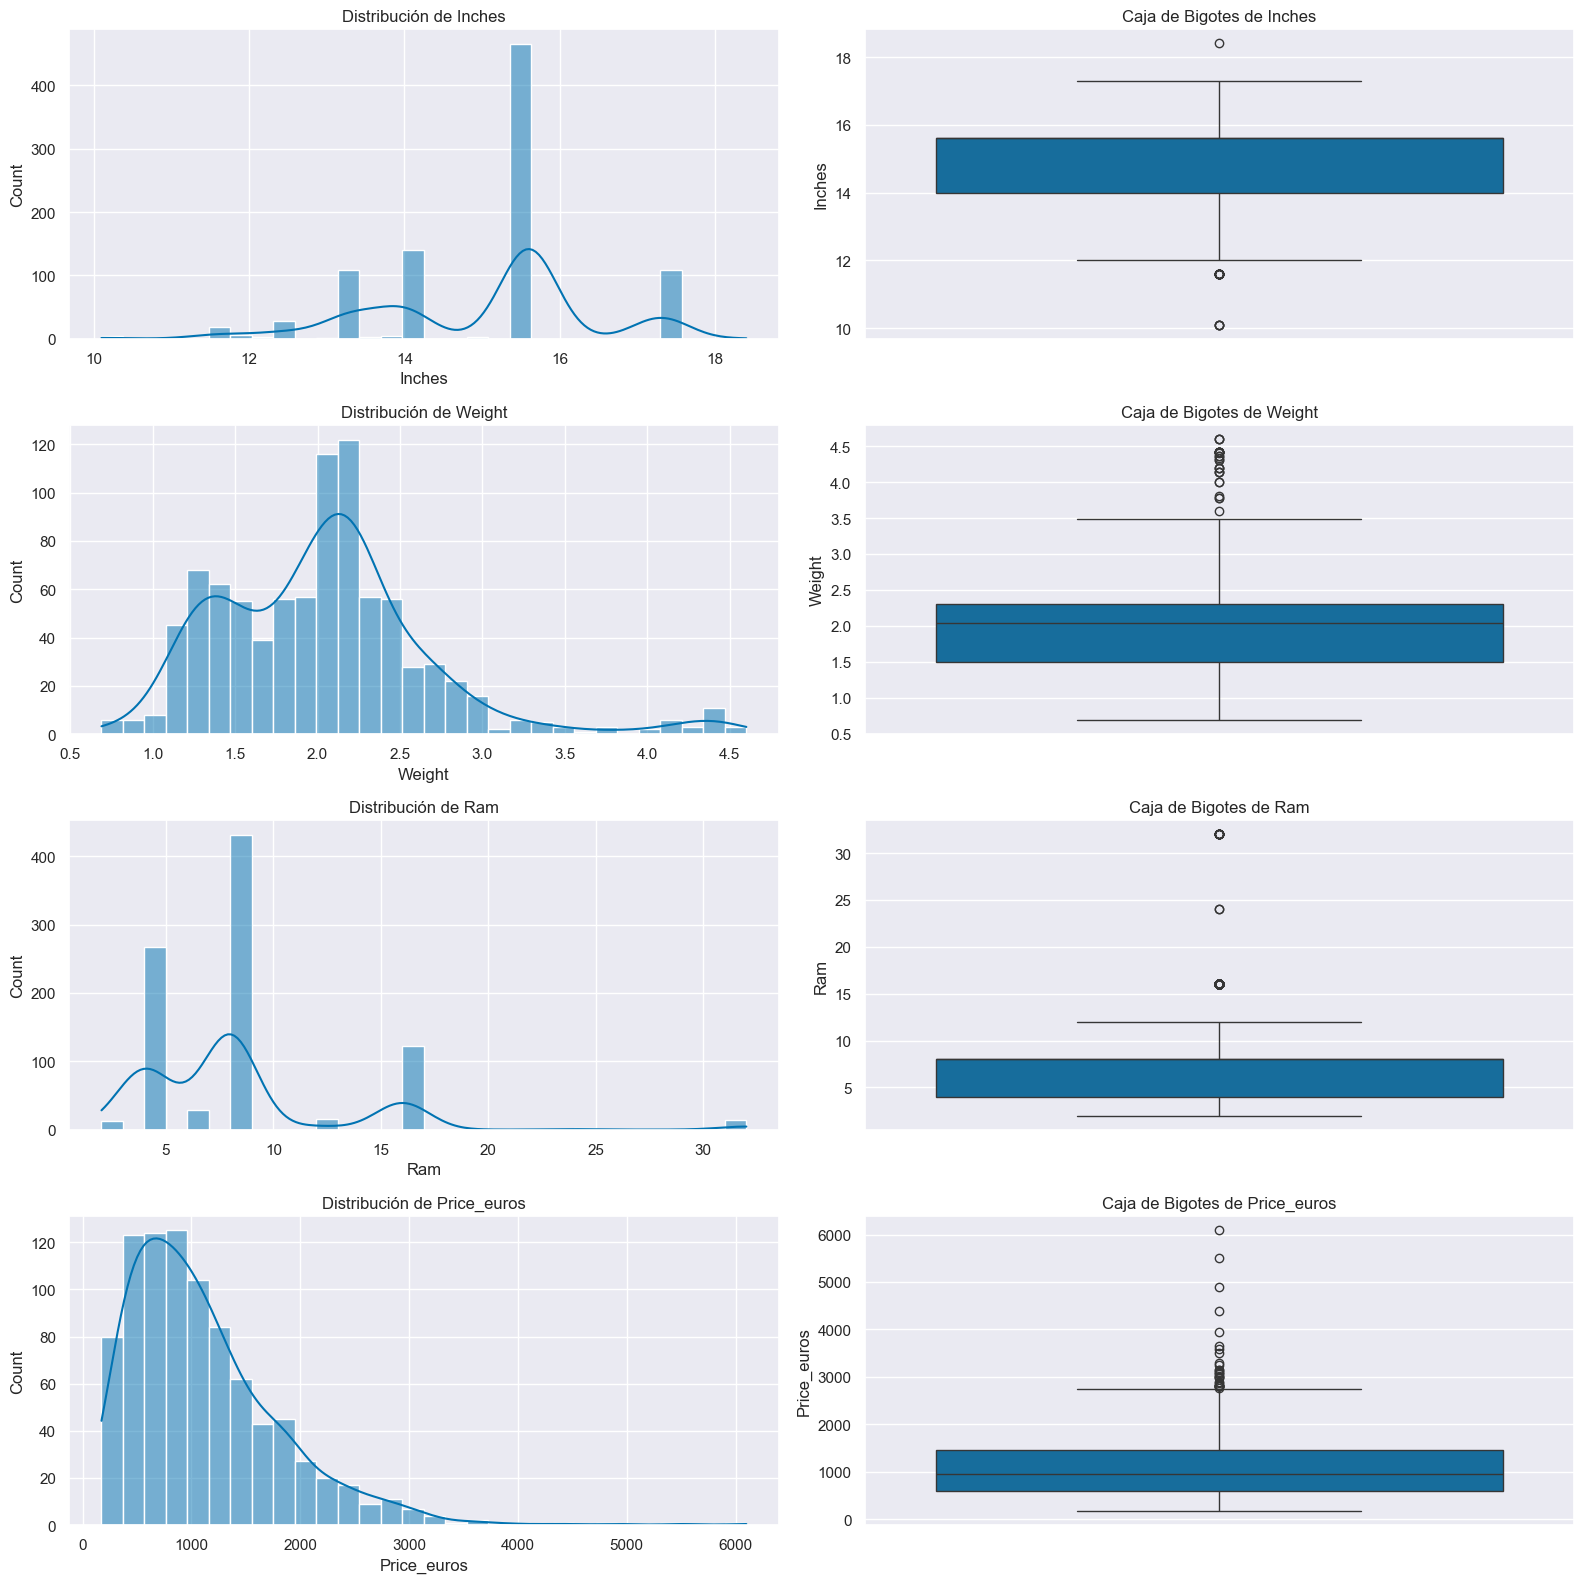

In [42]:
# Análisis univariante de características numéricas
numerical_features = ['Inches', 'Weight', 'Ram', 'Price_euros','Touchscreen',]

plt.figure(figsize=(16, 16))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, 2*i-1)
    sns.histplot(train_data[feature], bins=30, kde=True)
    plt.title(f'Distribución de {feature}')
    
    plt.subplot(4, 2, 2*i)
    sns.boxplot(y=train_data[feature])
    plt.title(f'Caja de Bigotes de {feature}')
plt.tight_layout()
plt.show()

Observaciones:
* Inches: La mayoría de los portátiles tienen un tamaño de pantalla entre 13 y 15 pulgadas.
* Weight: La mayoría de los portátiles pesan entre 1 y 2.5 kg, con algunos portátiles más pesados.
* Ram: La distribución de la memoria RAM muestra que 8GB y 16GB son las configuraciones más comunes.
* Price_euros: Los precios están asimétricamente distribuidos, con la mayoría de los precios en la gama más baja y algunos valores atípicos en   la gama alta.

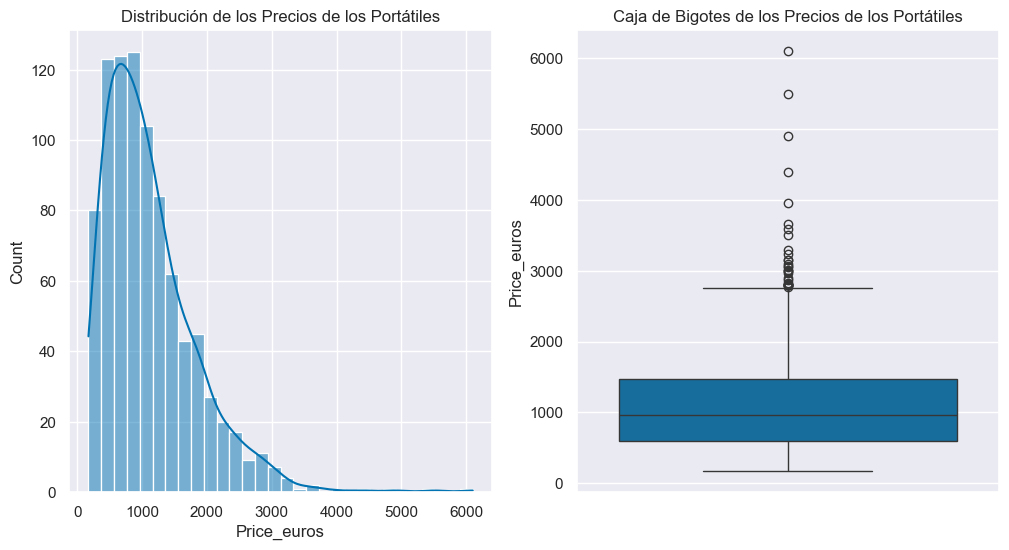

In [43]:
# Distribución de la variable objetivo (Price_euros)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['Price_euros'], bins=30, kde=True)
plt.title('Distribución de los Precios de los Portátiles')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['Price_euros'])
plt.title('Caja de Bigotes de los Precios de los Portátiles')
plt.show()

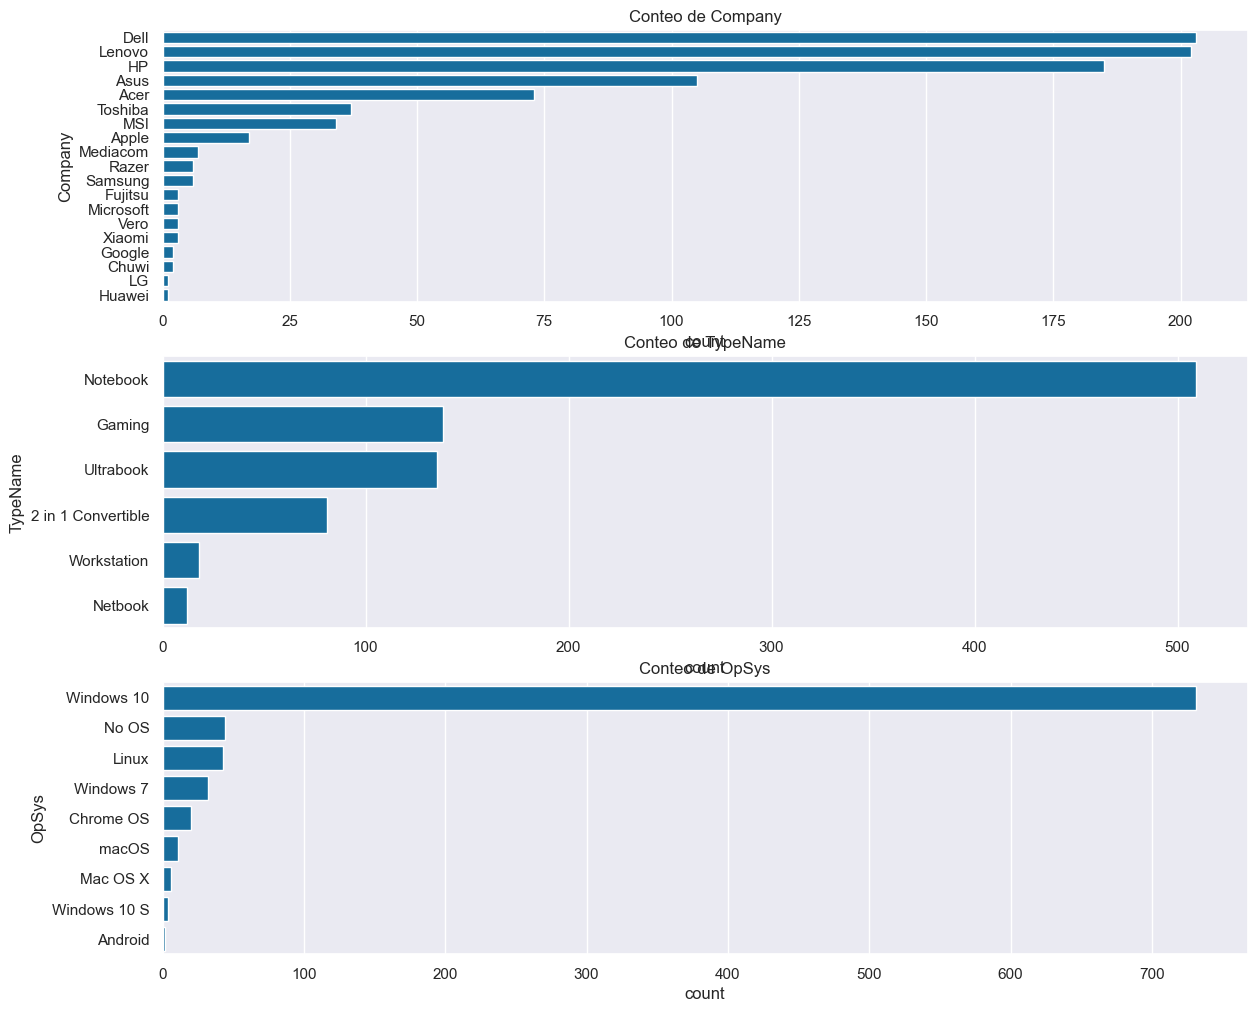

In [44]:
# Análisis univariante de características categóricas
categorical_features = ['Company', 'TypeName', 'OpSys']

plt.figure(figsize=(14, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 1, i)
    sns.countplot(y=train_data[feature], order=train_data[feature].value_counts().index)
    plt.title(f'Conteo de {feature}')
plt.show()


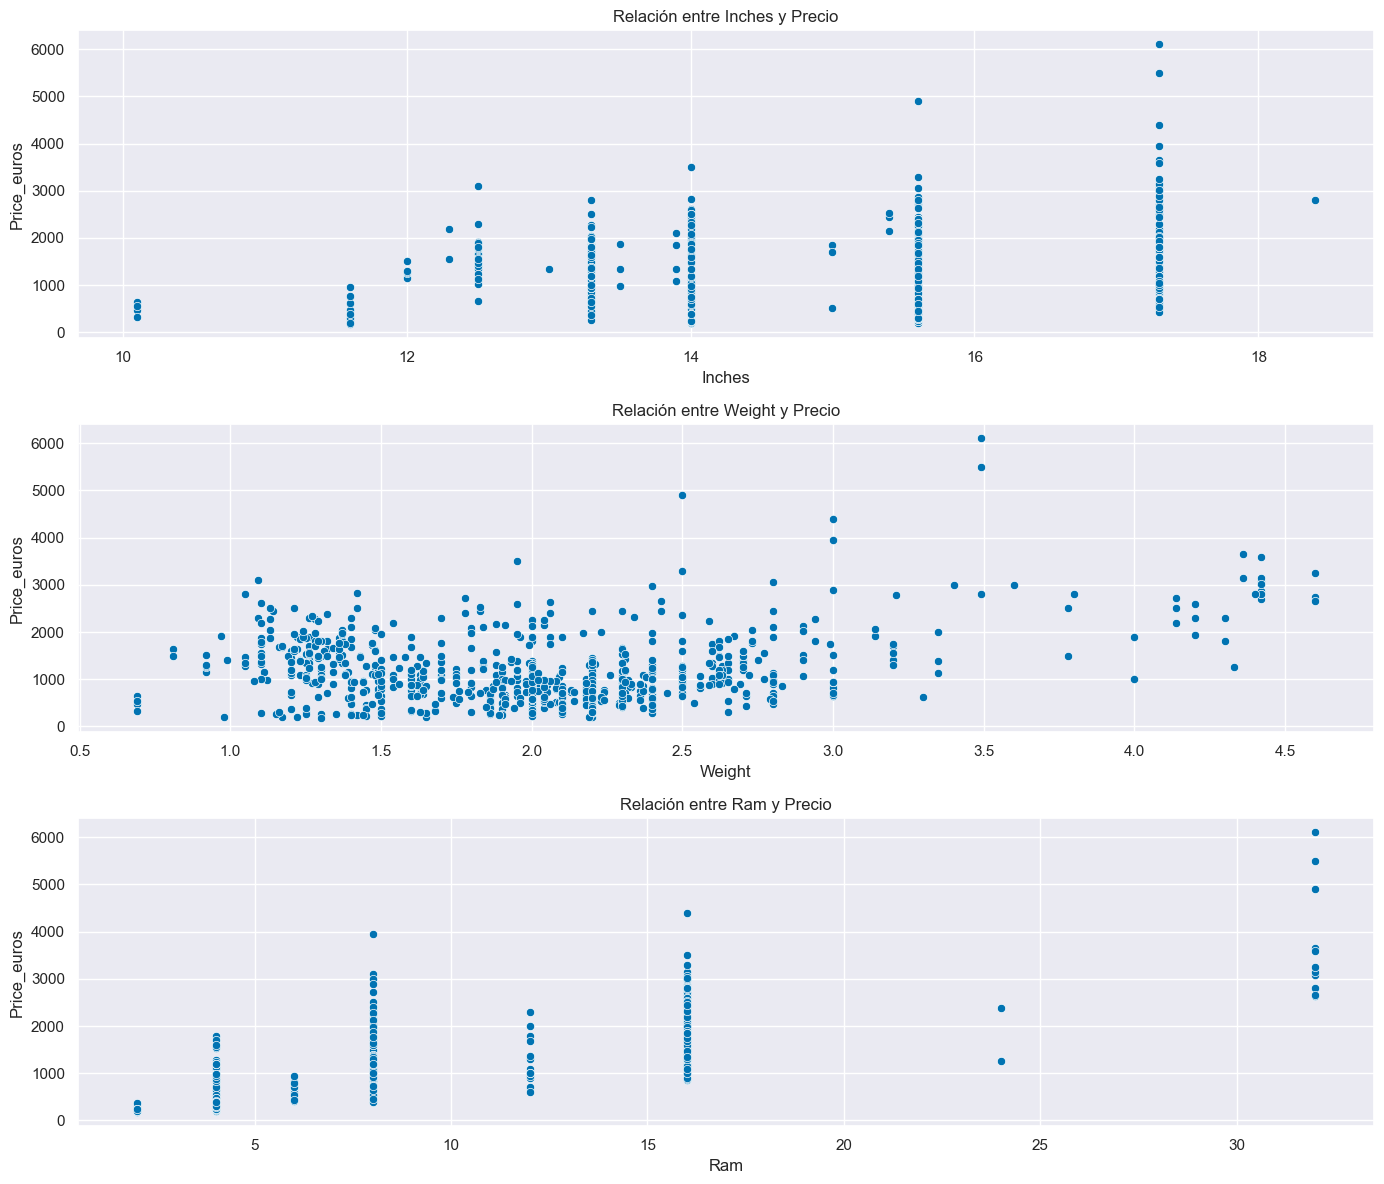

In [45]:
# Análisis bivariante: relación entre características numéricas y precio
plt.figure(figsize=(14, 12))
for i, feature in enumerate(numerical_features[:-1], 1):  # Excluimos 'Price_euros'
    plt.subplot(3, 1, i)
    sns.scatterplot(x=train_data[feature], y=train_data['Price_euros'])
    plt.title(f'Relación entre {feature} y Precio')
    plt.tight_layout()
plt.show()


Observaciones:
* Company: Hay diferencias notables en los precios entre diferentes compañías. Apple y Microsoft tienden a tener precios más altos.
* Product: La alta cardinalidad dificulta ver una tendencia clara sin agrupar.
* TypeName: Los portátiles para gaming y ultrabooks tienden a ser más caros que los notebooks.
* ScreenResolution: Las resoluciones más altas tienden a asociarse con precios más altos.
* Cpu: Gran variabilidad en los precios basada en la CPU.
* Memory: Las configuraciones de SSD tienden a ser más caras que las de HDD.
* Gpu: Las GPUs dedicadas tienden a ser más caras que las integradas.
* OpSys: Los portátiles con Mac OS y Linux tienden a ser más caros en comparación con los que tienen Windows.

In [46]:
# Pasos a seguir:
# Evaluar cardinalidad de características categóricas y ponerla en un df
"""Agrupar Categorías Menos Frecuentes:

Gpu y Cpu tienen alta cardinalidad y podrían ser agrupados en categorías más generales.
Transformación de Características Categóricas:

Realizar one-hot encoding para características categóricas con baja a moderada cardinalidad."""




'Agrupar Categorías Menos Frecuentes:\n\nGpu y Cpu tienen alta cardinalidad y podrían ser agrupados en categorías más generales.\nTransformación de Características Categóricas:\n\nRealizar one-hot encoding para características categóricas con baja a moderada cardinalidad.'

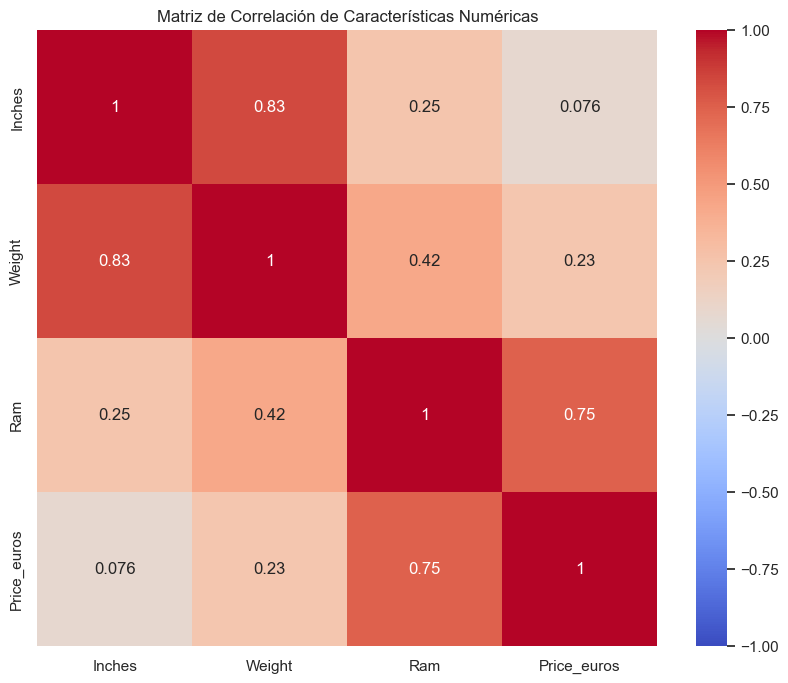

Correlación de Pearson entre Inches y Price_euros: 0.08
Correlación de Pearson entre Weight y Price_euros: 0.23
Correlación de Pearson entre Ram y Price_euros: 0.75


In [47]:
# Matriz de Correlación y Heatmap para características numéricas
numerical_features = ['Inches', 'Weight', 'Ram', 'Price_euros']
corr_matrix = train_data[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Características Numéricas')
plt.show()

# Correlación de Pearson entre características numéricas y la variable objetivo
from scipy.stats import pearsonr

for feature in numerical_features[:-1]:  # Excluimos 'Price_euros'
    corr, _ = pearsonr(train_data[feature], train_data['Price_euros'])
    print(f'Correlación de Pearson entre {feature} y Price_euros: {corr:.2f}')


In [48]:
# Prueba Chi-cuadrado para características categóricas
from scipy.stats import chi2_contingency

categorical_features = ['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Gpu', 'OpSys']
for feature in categorical_features:
    contingency_table = pd.crosstab(train_data[feature], train_data['Price_euros'])
    chi2, p, dof, ex = chi2_contingency(contingency_table, correction=False)
    print(f'Test Chi-cuadrado para {feature}: p-value = {p:.4f}')


Test Chi-cuadrado para Company: p-value = 1.0000
Test Chi-cuadrado para TypeName: p-value = 0.0000
Test Chi-cuadrado para ScreenResolution: p-value = 0.5700
Test Chi-cuadrado para Cpu: p-value = 0.0594
Test Chi-cuadrado para Gpu: p-value = 0.6622
Test Chi-cuadrado para OpSys: p-value = 0.0000


## Data processing

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

### 2. Dividir X_train, X_test, y_train, y_test

### 3. Crear y entrenar el modelo


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [49]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [50]:
predictions = model.predict(X_pred)
predictions

NameError: name 'model' is not defined

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("Dataset/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [ ]:
sample.head()

In [ ]:
sample.shape

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [ ]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
